In [1]:
###Steps to run the notebook###

#1. Make sure that VS Code and Anaconda run as administrator
#2. Launch VS code from anaconda
#3. Open Terminal, activate myenv in anaconda (environment located in rachel's account)
#4. Choose intepreter as myenv in VS Code (Python 3.9.16)
#5. Change the data_dir log_dir and data_dir paths of folders if not using the hard disk / want to save not in hard disk
#6. if have cuda, use the commented run function (original) and dont forget to change cpu to cuda

In [ ]:
DEBUG = False

import os
import sys
sys.path = [
    '/lustre1/g/eee_ultrasound/rachel_imseg/input/conv3d_same.py',
] + sys.path
import numpy
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #replace "cuda" if torch.cuda.is_available() else "cpu" if needed
torch.backends.cudnn.benchmark = True

: 

Config

In [2]:
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

image_sizes = [128, 128, 128]
R = Resize(image_sizes)

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '/lustre1/g/eee_ultrasound/rachel_imseg/input/rsna-2022-cervical-spine-fracture-detection'
use_amp = True
num_workers = 2 #4
out_dim = 7

n_epochs = 1000 #1000

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

Data Augmentation

In [3]:
transforms_train = transforms.Compose([
    #Randomly flips the image along axes. Preserves shape.
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),

    #Random affine transform
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),

    #Random grid distortions (RandGridDistortion** not sure why theres d in the 1st place code)
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),
])

transforms_valid = transforms.Compose([
])

DataFrame

In [6]:
#read training datafiles
df_train = pd.read_csv('input/rsna-2022-cervical-spine-fracture-detection/train.csv')

#get path to masks
mask_files = os.listdir('input/rsna-2022-cervical-spine-fracture-detection/segmentations')
#read masks
df_mask = pd.DataFrame({
    'mask_file': mask_files,
})

#get info from masks and resave it into a dataframe
df_mask['StudyInstanceUID'] = df_mask['mask_file'].apply(lambda x: x[:-4])
df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir, 'segmentations', x))
df = df_train.merge(df_mask, on='StudyInstanceUID', how='left')
df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(data_dir, 'train_images', x))
df['mask_file'].fillna('', inplace=True)

df_seg = df.query('mask_file != ""').reset_index(drop=True)

#KFold will provide train/test indices to split data in train and test sets.
#It will split dataset into k consecutive folds (without shuffling by default).
#Each fold is then used a validation set once while the k - 1 remaining folds form the training set
kf = KFold(5)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail() #return the last 5 rows

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,fold
82,1.2.826.0.1.3680043.32071,1,0,1,0,1,0,1,1,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,4
83,1.2.826.0.1.3680043.30524,1,0,0,0,0,0,1,1,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,4
84,1.2.826.0.1.3680043.28025,0,0,0,0,0,0,0,0,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,4
85,1.2.826.0.1.3680043.21321,1,1,1,1,0,0,0,1,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,4
86,1.2.826.0.1.3680043.26990,1,0,0,0,0,1,1,1,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,/lustre1/g/eee_ultrasound/rachel_imseg/input/r...,4


Dataset

In [7]:
revert_list = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

In [8]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = cv2.resize(data, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)
    return data


def load_dicom_line_par(path):

    t_paths = sorted(glob(os.path.join(path, "*")),
       key=lambda x: int(x.split('/')[-1].split(".")[0]))
    n_scans = len(t_paths)
    # print(n_scans)
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
    t_paths = [t_paths[i] for i in indices]
    images = []
    for filename in t_paths:
        # print(filename)
        images.append(load_dicom(filename))
    images = np.stack(images, -1)

    images = images - np.min(images)
    images = images / (np.max(images) + 1e-4)
    images = (images * 255).astype(np.uint8)
    return images


def load_sample(row, has_mask=True):
    #ndim is same with .shape[0]
    image = load_dicom_line_par(row.image_folder)
    
    if image.ndim < 4:
        image = np.expand_dims(image, 0).repeat(3, 0)  # to 3ch
    #mask is in .nii
    if has_mask:
        mask_org = nib.load(row.mask_file).get_fdata()
        shape = mask_org.shape
        mask_org = mask_org.transpose(1, 0, 2)[::-1, :, ::-1]  # (d, w, h)
        mask = np.zeros((7, shape[0], shape[1], shape[2]))
        for cid in range(7):
            mask[cid] = (mask_org == (cid+1))
        mask = mask.astype(np.uint8) * 255
        mask = R(mask).numpy()
        # print(mask)
        return image, mask
    else:
        return image


#used in dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
#and dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        ### using local cache #i added f'{"train_images"}' because it doesnt lead inside
        #image_file = os.path.join(data_dir, f'{"train_images"}', f'{row.StudyInstanceUID}.npy')
        #image_file = image_file.replace('\\', '/')
        #image_file = os.path.normpath(image_file)
        #mask_file = os.path.join(data_dir, f'{"train_images"}', f'{row.StudyInstanceUID}_mask.npy')
        #mask_file = mask_file.replace('\\', '/')
        #mask_file = os.path.normpath(mask_file)
        #image = np.load(image_file).astype(np.float32)
        #mask = np.load(mask_file).astype(np.float32)

        image, mask = load_sample(row, has_mask=True)

        if row.StudyInstanceUID in revert_list:
            mask = mask[:, :, :, ::-1]

        res = self.transform({'image':image, 'mask':mask})
        #print(image)
        image = res['image'] / 255.
        mask = res['mask']
        #print(mask)
        #plt.imshow(mask)
        mask = (mask > 127).astype(np.float32)
        #mask = (mask).astype(np.float32)
        #print('after 127')
        #plt.imshow(mask)
        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
        return image, mask


In [9]:
rcParams['figure.figsize'] = 20,8
#create image and mask for training
df_show = df_seg
dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)
# SEGDataset(df_show, 'train', transform=transforms_train)

/tmp/jobtmp-racheln-1362815/ipykernel_89628/3968966118.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


this is mask
this is modified mask


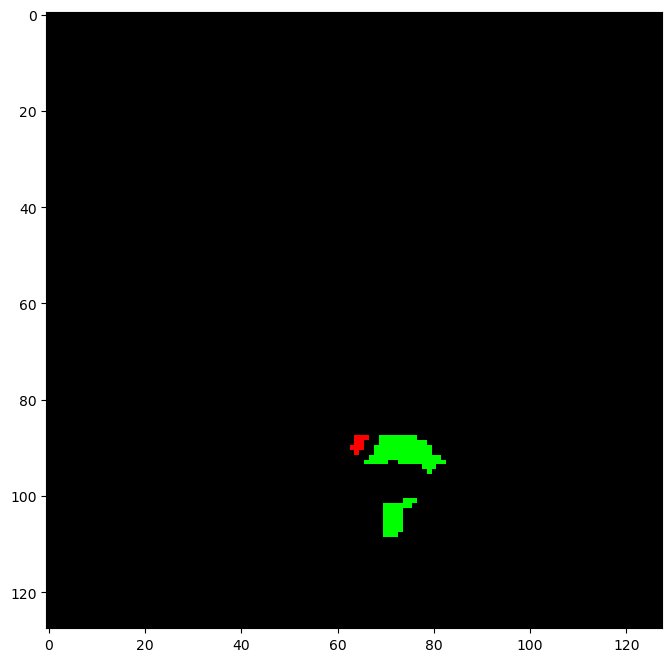

In [10]:
img, mask = dataset_show[0]
#print(img)
print('this is mask')
mask = mask[:, :, :, 60]
mask[0] = mask[0] + mask[3] + mask[6]
mask[1] = mask[1] + mask[4]
mask[2] = mask[2] + mask[5]
mask = mask[:3]
print('this is modified mask')
plt.imshow(mask.transpose(0, 1).transpose(1,2).squeeze())

/tmp/jobtmp-racheln-1362386/ipykernel_6109/3968966118.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


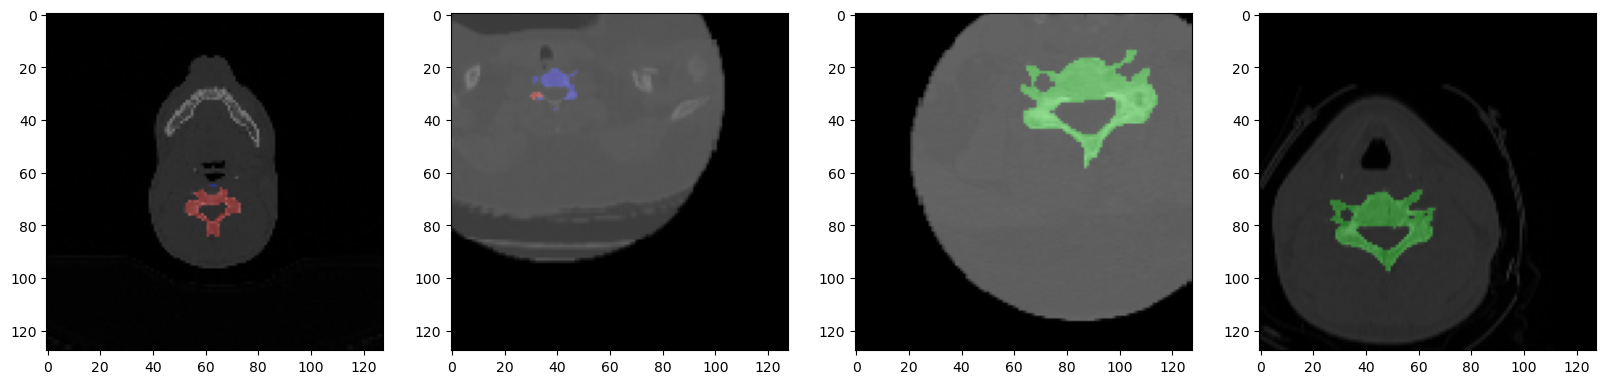

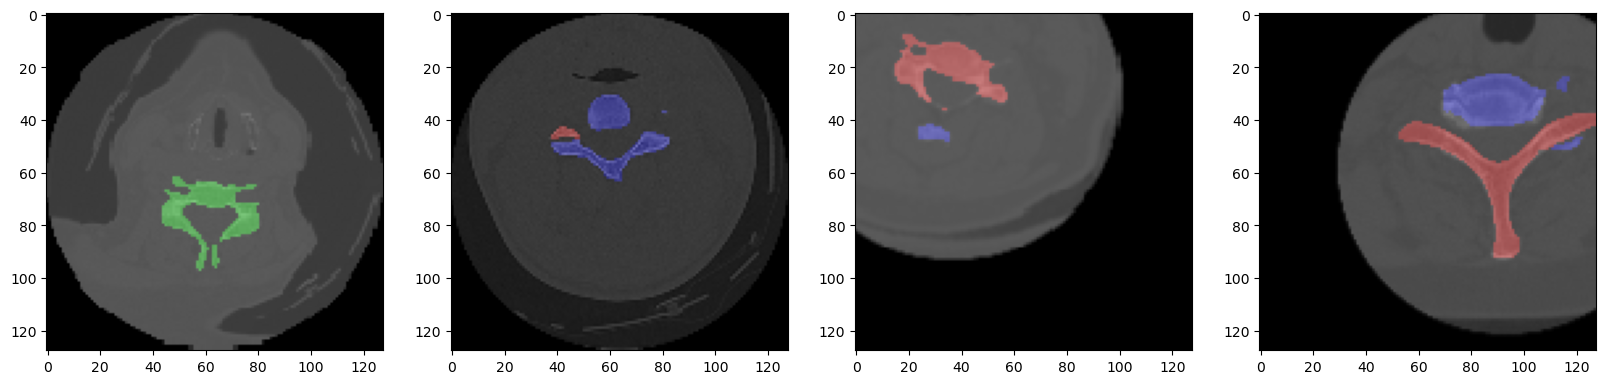

In [58]:
#display images
for i in range(2):
    f, axarr = plt.subplots(1,4)
    for p in range(4): #4
        idx = i*4+p
        img, mask = dataset_show[idx]
        img = img[:, :, :, 60]
        mask = mask[:, :, :, 60]
        mask[0] = mask[0] + mask[3] + mask[6]
        mask[1] = mask[1] + mask[4]
        mask[2] = mask[2] + mask[5]
        mask = mask[:3]
        img = img * 0.7 + mask * 0.3
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())

Model

In [11]:
class TimmSegModel(nn.Module):
  #if not yet trained then initialize
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__() #calls parent class

        #PyTorch Image Models (timm) see https://timm.fast.ai/
        #timm has pretrained and non pretrained models
        #tutorial link https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055#03bd

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        #torch.rand -> use a random tensor to represent single channel image
        #should be finetuned
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]

        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Optional, List


# Calculate symmetric padding for a convolution
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x: int, k: int, s: int, d: int):
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)


# Can SAME padding for given args be done statically?
def is_static_pad(kernel_size: int, stride: int = 1, dilation: int = 1, **_):
    return stride == 1 and (dilation * (kernel_size - 1)) % 2 == 0


# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, k: List[int], s: List[int], d: List[int] = (1, 1, 1), value: float = 0):
    ih, iw, iz = x.size()[-3:]
    pad_h = get_same_padding(ih, k[0], s[0], d[0])
    pad_w = get_same_padding(iw, k[1], s[1], d[1])
    pad_z = get_same_padding(iz, k[2], s[2], d[2])
    if pad_h > 0 or pad_w > 0 or pad_z > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2, pad_z // 2, pad_z - pad_z // 2], value=value)
    return x


def get_padding_value(padding, kernel_size, **kwargs) -> Tuple[Tuple, bool]:
    dynamic = False
    if isinstance(padding, str):
        # for any string padding, the padding will be calculated for you, one of three ways
        padding = padding.lower()
        if padding == 'same':
            # TF compatible 'SAME' padding, has a performance and GPU memory allocation impact
            if is_static_pad(kernel_size, **kwargs):
                # static case, no extra overhead
                padding = get_padding(kernel_size, **kwargs)
            else:
                # dynamic 'SAME' padding, has runtime/GPU memory overhead
                padding = 0
                dynamic = True
        elif padding == 'valid':
            # 'VALID' padding, same as padding=0
            padding = 0
        else:
            # Default to PyTorch style 'same'-ish symmetric padding
            padding = get_padding(kernel_size, **kwargs)
    return padding, dynamic


def conv3d_same(
        x, weight: torch.Tensor, bias: Optional[torch.Tensor] = None, stride: Tuple[int, int, int] = (1, 1, 1),
        padding: Tuple[int, int, int] = (0, 0, 0), dilation: Tuple[int, int, int] = (1, 1, 1), groups: int = 1):
    x = pad_same(x, weight.shape[-3:], stride, dilation)
    return F.conv3d(x, weight, bias, stride, (0, 0, 0), dilation, groups)


class Conv3dSame(nn.Conv3d):
    """ Tensorflow like 'SAME' convolution wrapper for 3d convolutions
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv3dSame, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        return conv3d_same(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


def create_conv3d_pad(in_chs, out_chs, kernel_size, **kwargs):
    padding = kwargs.pop('padding', '')
    kwargs.setdefault('bias', False)
    padding, is_dynamic = get_padding_value(padding, kernel_size, **kwargs)
    if is_dynamic:
        return Conv3dSame(in_chs, out_chs, kernel_size, **kwargs)
    else:
        return nn.Conv3d(in_chs, out_chs, kernel_size, padding=padding, **kwargs)

In [13]:
# sys.path = [
#     '/lustre1/g/eee_ultrasound/rachel_imseg/input/conv3d_same.py',
# ] 
from timm.models.layers.conv2d_same import Conv2dSame
# from conv3d_same.py import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig

    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output

m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 3, 128,128,128)).shape

#check the config of the model by command below
#m.default_cfg

torch.Size([1, 7, 128, 128, 128])

Loss and Metric

In [14]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

Train and Valid Function

In [15]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cuda(),
                        y_true=gt_masks[i].cuda(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)


/home/racheln/.conda/envs/rachelenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/racheln/.conda/envs/rachelenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are 

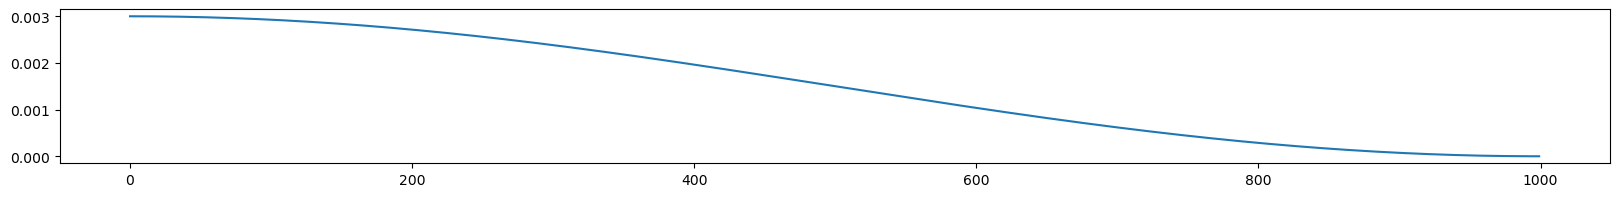

In [16]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

Training

In [ ]:
# def run(fold):

#     log_file = os.path.join(log_dir, f'{kernel_type}.txt')
#     model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

#     train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
#     valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
#     dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
#     dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
#     loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
#     loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#     model = TimmSegModel(backbone, pretrained=True)
#     model = convert_3d(model)
#     model = model.to(device)

#     optimizer = optim.AdamW(model.parameters(), lr=init_lr)
#     scaler = torch.cuda.amp.GradScaler()
#     from_epoch = 0
#     metric_best = 0.
#     loss_min = np.inf

#     scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

#     print(len(dataset_train), len(dataset_valid))

#     for epoch in range(1, n_epochs+1):
#         scheduler_cosine.step(epoch-1)

#         print(time.ctime(), 'Epoch:', epoch)

#         train_loss = train_func(model, loader_train, optimizer, scaler)
#         valid_loss, metric = valid_func(model, loader_valid)

#         content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
#         print(content)
#         with open(log_file, 'a') as appender:
#             appender.write(content + '\n')

#         if metric > metric_best:
#             print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             torch.save(model.state_dict(), model_file)
#             metric_best = metric

#         # Save Last
#         if not DEBUG:
#             torch.save(
#                 {
#                     'epoch': epoch,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'scaler_state_dict': scaler.state_dict() if scaler else None,
#                     'score_best': metric_best,
#                 },
#                 model_file.replace('_best', '_last')
#             )

#     del model
#     torch.cuda.empty_cache()
#     gc.collect()

In [17]:
def run(fold):
    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    device = torch.device("cuda")  # Set the device to CPU
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    # torch.cpu.empty_cache()
    gc.collect()


In [18]:
run(0)
run(1)
run(2)
run(3)
run(4)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx